# Generativity and Adversarial Gradients

**Purpose:** see `02`, this notebook adds in a hack to the `learn()` method, which forces generator weights to `==` the discriinator

# Imports

In [1]:
from typing import List

import copy
import os
import pathlib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using {device = }")

using device = 'cuda'


# Metrics

In [3]:
def accuracy(net, dl):
    total_correct = 0.
    for x,t in dl:
        y = net(x.to(device))
        blah = torch.argmax(y.cpu(), dim=1)
        total_correct += torch.sum(blah==t).cpu().item()
    return total_correct/len(dl.dataset)

# Plotting

In [4]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');

    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [6]:
def save_plot(plot, path, title):
    pass

# Network

In [8]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)
     
     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).
     
     It projects to a latent space.
     From that latent space, it:
      1) projects to an output classification layer (log softmax), and
      2) projects back down through the network to a reconstruction of the input.
     
    '''
    def __init__(self, img_size=28, latent_dim=5):
        super().__init__()
        
        # Discriminative network
        self.D = nn.ModuleList()
        
        # Input -> Hidden 1
        self.D.append(nn.Linear(img_size**2, 100))
        self.D.append(nn.ReLU())
        
        # Hidden 1 -> Hidden 2
        self.D.append(nn.Linear(100, latent_dim))
        self.D.append(nn.ReLU())
        
        # Classifier
        self.classifier = nn.Sequential(
                            nn.Linear(latent_dim, 10),
                            nn.LogSoftmax(dim=-1),
                            )

        # The generative network
        self.G = nn.ModuleList()
        
        # Hidden 2 -> Hidden 1
        self.G.append(nn.Linear(latent_dim, 100))
        self.G.append(nn.ReLU())
        
        # Hidden 1 -> Input
        self.G.append(nn.Linear(100, img_size**2))
        self.G.append(nn.Sigmoid())
        
        # Tie the weights of D and G
        #TODO check if pointer or copy
        self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
        self.G[-4].weight.data = self.D[2].weight.data.transpose(1,0)
        self.G[-4].bias.data = self.D[0].bias.data
        
        self.classifier_loss = nn.NLLLoss()
        self.recon_loss = nn.BCELoss()
        self.losses = []
        self.to(device)
        
        # checkpoint states
        self.optimizer = None
        
        
    def forward(self, x):
        '''Latent -> Classification'''
        return self.classifier(self.discriminate(x))

    
    def ae(self,x):
        return self.generate(self.discriminate(x))

    
    def discriminate(self, x):
        '''Input -> Latent'''
        for d in self.D:
            x = d(x)
        return x


    def generate(self, z):
        '''
         Latent -> Input
         x_had = net.generate(z)
         
         Runs the network in reverse, generating a batch of inputs from
         a batch of latent vectors.
         
         Inputs:
          z      (D,latent_dim) tensor of latent vectors
          
         Outputs:
          x_hat  (D,784) tensor containing the batch of inputs
        '''
        for g in self.G:
            z = g(z)
        return z
    
      
    def learn(self, 
              dl, 
              optimizer=None, 
              epochs=10, 
              beta=0.,
              checkpoints=[],
              path: str=None):
        '''
         net.learn(dl, optimizer=None, epochs=10, beta=0.)
         
         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().
         
         The targets for the dataset are assumed to be class indices.
         
         beta is the weight for the reconstruction loss.
         
         Args:
         
             checkpoints (Boolean|List[int]): if True, save every 10-epochs. if List[int], save each listed epoch.
             path (str): optional path to save model checkpoints.
        '''
        if optimizer is None:
            print('Need to specify an optimizer')
            return
        else:
            self.optimizer = optimizer
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                z = self.discriminate(x)
                y = self.classifier(z)
                xhat = self.generate(z)
                loss = self.classifier_loss(y, t) + beta*self.recon_loss(xhat, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
                # set generator weights to equal discirminator weights
                # hack fix
                self.G[0].weight.data = self.D[2].weight.data.transpose(1,0)
                self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
                # delete above hack
            self.losses.append(total_loss/len(dl.dataset))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
            if checkpoints:
                self.checkpoint(epoch, checkpoints, path)
                
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');


    def checkpoint(self, 
                   epoch: int, 
                   checkpoints: List[int]=[],
                   path: str="model-checkpoints.pt"):
        """ Save model checkpoints. 
        
            Args:
                epoch (int): Current training epoch.
                checkpoints (List[int]): list of epochs to save model at. if True, save every 10.model 
                path (str): path to save model.pt, not required if checkpoints is False.
                
        """
        
        def save_checkpoint(self, epoch, path):
            path = path.split(".pt")[0] + f"-{epoch}" + ".pt"
            torch.save({'epoch': epoch,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'loss': self.losses[-1],
                        }, 
                        path) 
        
        if checkpoints is True:
            if epoch % 10 == 0: 
                save_checkpoint(self, epoch, path)
        elif epoch in checkpoints:
            save_checkpoint(self, epoch, path)     

# Dataset: MNIST

In [9]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [10]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

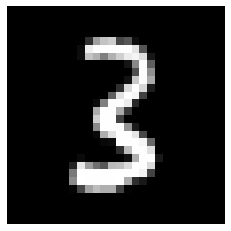

In [11]:
# plot a single random digit image
x,t = ds_full.__getitem__(50000)
draw(x)

In [12]:
len(ds_full)

60000

# Train/Load network
You can train the network yourself. However, if you would rather skip that part, a pre-trained network is supplied. That is what will be run by default.

Train network while saving epoch checkpoints

In [13]:
#ds = ds_full
n = 1024*2
n_samples = n if n <= len(ds_full) else len(ds_full)
# how many samples to train on 
ds = torch.utils.data.Subset(ds_full, range(n_samples))

In [14]:
%pwd

'C:\\Users\\bcech\\Documents\\MMath\\thesis\\anti_adv\\notebooks'

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.25it/s]


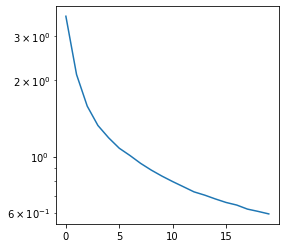

In [15]:
net = MyNet(img_size, latent_dim=8)#.to(device)

assert torch.equal(net.G[-2].weight.data.T, net.D[0].weight.data)
assert torch.equal(net.G[-4].weight.data.T, net.D[2].weight.data)

dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
# Uncomment the next line if you want to train it yourself.
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
checkpoints = [0,1,2,9,49]
path = f"../data/06_models/debug/hack-mnist-{len(dl)}-checkpoint.pt"
net.learn(dl, 
          optimizer=optimizer, 
          epochs=20, 
          beta=3., 
          checkpoints=checkpoints,
          path=path)

In [16]:
# check post-training if still true
assert torch.equal(net.G[-2].weight.data.T, net.D[0].weight.data)
assert torch.equal(net.G[-4].weight.data.T, net.D[2].weight.data)

In [17]:
# Use the line below to load a pre-trained network from a file.
# Note that the MyNet class should be defined for this to work.
#net = torch.load('mnist_trained.pt').to(device)

In [18]:
# If you'd like some confidence that the network is well trained, you can
# test its accuracy.
# The supplied network should have a test accuracy over 97%.

dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256)
acc = accuracy(net, dl)
print(f'Training Accuracy = {acc*100.:0.2f}%')
acc = accuracy(net, dl_test)
print(f'    Test Accuracy = {acc*100.:0.2f}%')

Training Accuracy = 98.78%
    Test Accuracy = 91.51%


Load each checkpoint and plot accuracy evolution

{0: 0.3609, 1: 0.6463, 2: 0.727, 9: 0.8913, 49: 0.9122}


<AxesSubplot:title={'center':'model test accuracy by epoch'}>

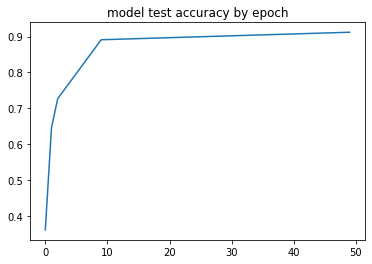

In [26]:
paths = [filepath.absolute() for filepath in pathlib.Path("../data/06_models/debug").glob("hack-mnist-*.pt")]
# sort by model epoch, re-ordering glob.glot()
paths = sorted(paths, key=lambda x: int(os.path.basename(x).split('-')[-1].split(".")[0]))
model = copy.deepcopy(net)
accuracies = {}
for path in paths:
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    accuracies[epoch]=(accuracy(model, dl_test))

print(accuracies)
pd.Series(accuracies).plot(kind='line', title="model test accuracy by epoch")

# Running the network backwards

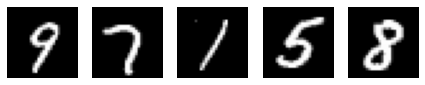

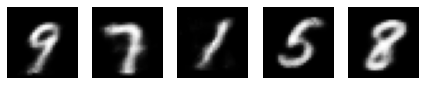

In [27]:
x,t = next(iter(dl))   # TODO Freeze for multi training runs 
y = net.generate(net.discriminate(x.to(device)))  # Encode, then generate from that encoding
draw(x[:5])
draw(y[:5])

## What do the Generator (adversarial) gradients look like?

In [28]:
x.requires_grad = True
# Feedforward
y = net(x.to(device))

In [29]:
# Compute loss and propagate gradients
loss = net.classifier_loss(y, t.to(device))
net.zero_grad()
loss.backward()    # altnerative, call with some t that changes the input (to some incorrect target) 

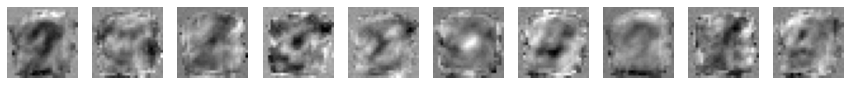

In [30]:
draw(x.grad[:10])

## How to Generator (adversarial) gradients look over training evolution?

plotting epochs: 0, 0, 1, 1, 2, 5, 9, 10, 20, 49, 49, 

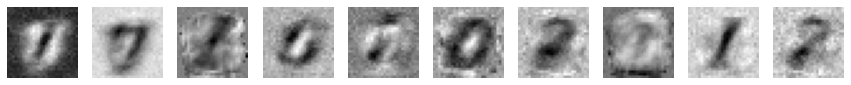

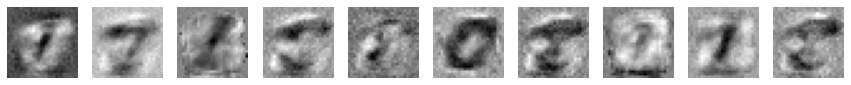

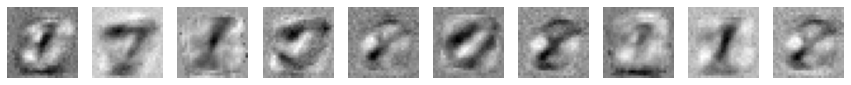

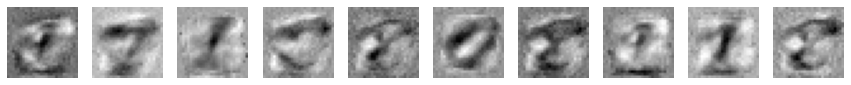

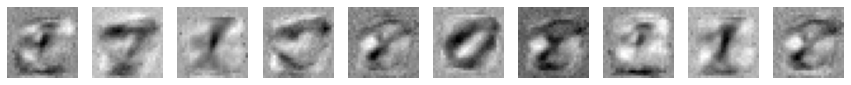

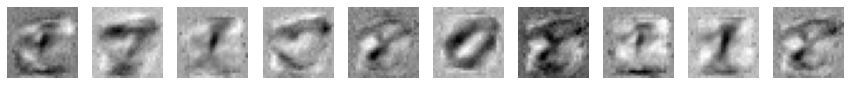

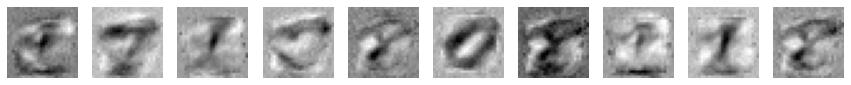

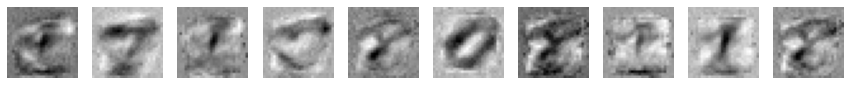

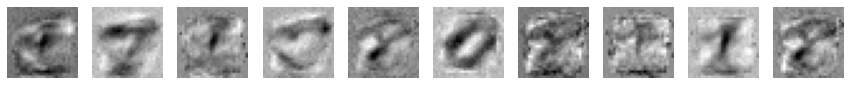

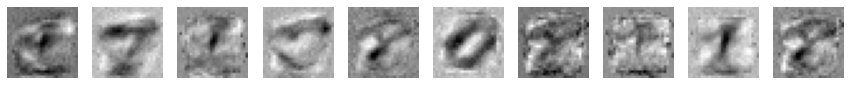

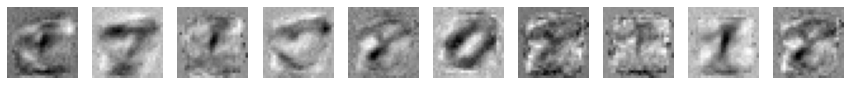

In [31]:
paths = [filepath.absolute() for filepath in pathlib.Path("../data/06_models/debug").glob("*.pt")]
paths = sorted(paths, key=lambda x: int(os.path.basename(x).split('-')[-1].split(".")[0]))
model = copy.deepcopy(net)    # just in case, don't mess with net obj


print("plotting epochs:", end=" ")
for path in paths:
    
    # load model checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()

    # Compute loss and propagate gradients
    y = model(x.to(device))
    loss = model.classifier_loss(y, t.to(device))
    model.zero_grad()
    loss.backward()
    
    # draw grad subplot line
    print(f"{epoch}", end=", ")
    #draw(torch.sign(x.grad[:10]))
    draw(x.grad[:10])

**Observations**: little appears to change in the adversarial gradients, during epoch evolution. some "grainy-ness" disappears. 

1. But, of potentially more interest, is that the gradients appear wildly inconsistent across different networks trained. 
2. as $n_{samples}$ increases, the change in gradient across epochs is less pronounced. TODO will be small sample size plot saving. 


next

1. turn generative loss down to zero
2. train just on classifier loss
3. check those gradients. 

----

4. generate adverarial examples - investigate
5. what do _these_ gradients look like? 

# A. `fgsm` Method

In [32]:
def fgsm(net, x, t, eps=0.01, targ=False):
    """
        x_adv = FGSM(net, x, t, eps=0.01, targ=False)
        
        Performs the Fast Gradient Sign Method, perturbing each input by
        eps (in infinity norm) in an attempt to have it misclassified.
        
        args:
          net    PyTorch Module object
          x      DxI tensor of a batch of inputs
          t      tensor of D corresponding class indices
          eps    the maximum infinity-norm perturbation from the input
          targ   Boolean, indicating if the FGSM is targetted
                   - if targ is False, then t is considered to be the true
                     class of the input, and FGSM will work to increase the cost
                     for that target
                   - if targ is True, then t is considered to be the target
                     class for the perturbation, and FGSM will work to decrease the
                     cost of the output for that target class
        
        return:
          x_adv  tensor of a batch of adversarial inputs, the same size as x
    """
    
    # Set the sign of the gradient-sign update [!!]
    signed_eps = -eps if targ else eps
    # If targetted, signed_eps should be negative
    # If not targetted, signed_eps should be positive
    # Tell PyTorch that we want to track the gradient all the way down to the input
    x.requires_grad = True
    # Feedforward
    y = net(x)
    # Compute loss and propagate gradients
    loss = net.classifier_loss(y, t)
    net.zero_grad()
    loss.backward()
    # The no_grad() is not really necessary
    with torch.no_grad():
        # Add +/-eps to each pixel
        x_adv = x + signed_eps * torch.sign(x.grad)
    
    return x_adv

# B. Untargetted

In [220]:
dl_all = torch.utils.data.DataLoader(ds, batch_size=len(ds), shuffle=False)

In [225]:
# Extract 10 digits from MNIST classified correctly by the network
# It is OK to just hardcode 10 digits and show they are classified correctly.
x_class = []
for i in range(0, 10):
    while True:
        j = np.random.randint(0, len(ds))
        x,t = ds_full.__getitem__(j)
        if t == i:
            y = net(x.to(device))
            if torch.argmax(y) == i:
                x_class.append(j)
                break
print(x_class)

# Create a batch with those 10 samples
ds_digits = torch.utils.data.Subset(ds_full, x_class)
dl_digits = torch.utils.data.DataLoader(ds_digits, batch_size=len(ds_digits))
x,t = next(iter(dl_digits))


[399, 7454, 3799, 7600, 6753, 7670, 14421, 84, 2810, 3044]


In [226]:
# Call fgsm on that batch

# brian hack: move net back to cpu, as 
# on gpu got weird grad error for x flag. unclear
x_adv = fgsm(net.to('cpu'), x, t, eps=0.05, targ=False)

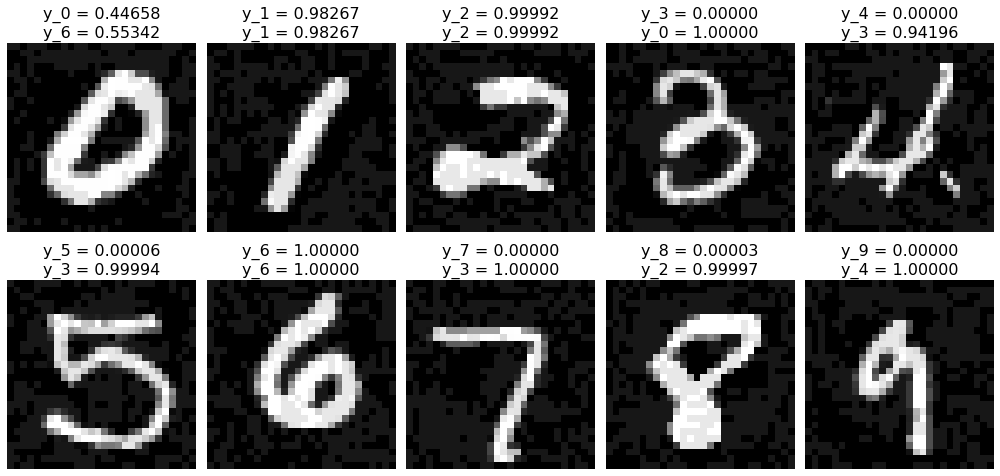

In [227]:
plt.figure(figsize=(14,7))
y = torch.exp(net(x_adv))
for n,xx in enumerate(x_adv):
    k = torch.argmax(y[n])
    plt.subplot(2,5,n+1); draw(xx);
    plt.title(f'y_{t[n]} = {y[n,t[n]]:0.5f}\ny_{k} = {y[n,k]:0.5f}', fontsize=16)
plt.tight_layout()
#plt.savefig('untargetted_adv.pdf')


## How do Generator (adversarial) gradients look 

In [237]:
x_adv

tensor([[-0.0500,  0.0500,  0.0500,  ..., -0.0500, -0.0500,  0.0500],
        [ 0.0500,  0.0500,  0.0500,  ..., -0.0500,  0.0500,  0.0500],
        [ 0.0500,  0.0500,  0.0500,  ...,  0.0500,  0.0500,  0.0500]])

In [236]:
paths = [f"model-checkpoint-{checkpoint}.pt" for checkpoint in checkpoints]
model = copy.deepcopy(net)    # just in case, don't mess with net obj


print("plotting epochs:", end=" ")
for path in paths:
    
    # load model checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()

    # Compute loss and propagate gradients
    y = model(x_adv)
    loss = model.classifier_loss(y, t)
    model.zero_grad()
    loss.backward()
    
    # draw grad subplot line
    print(f"{epoch}", end=", ")
    draw(x_adv.grad[:10])

plotting epochs: 0, 

TypeError: 'NoneType' object is not subscriptable

# C. Targetted

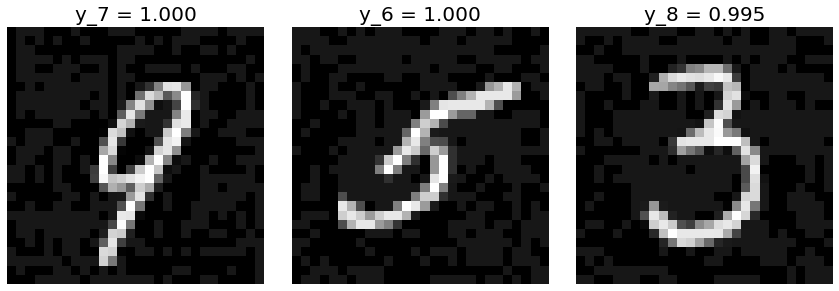

In [229]:
# Grading Notes:
# - Did they run fgsm properly (eps=0.05)?
# - Are the 3 adversarial inputs misclassified?
# - Did they display the probability of the incorrect class?
# - Did they display the adversarial image?

# Create a batch with 3 different digits
ds_select = torch.utils.data.Subset(ds_full, [22, 35, 50])
dl_select = torch.utils.data.DataLoader(ds_select, batch_size=len(ds_select), shuffle=False)
x,t = next(iter(dl_select))
# Run targetted fgsm on those digits...
targets = torch.tensor([7, 6, 8])
x_adv = fgsm(net, x, targets, eps=0.05, targ=True)

# ... and display the results.
y = torch.exp(net(x_adv))
plt.figure(figsize=(12,4))
for n,xx in enumerate(x_adv):
    k = torch.argmax(y[n])
    plt.subplot(1,3,n+1); draw(xx);
    plt.title(f'y_{k} = {y[n,k]:0.3f}', fontsize=20);
plt.tight_layout()
#plt.savefig('targetted_adv.pdf');
